In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

In [17]:
# URLs for CDCR monthly parole hearing data
URLS = ["https://www.cdcr.ca.gov/bph/2021/06/25/hearing-results-may-2021/", "https://www.cdcr.ca.gov/bph/2022/07/20/hearing-results-june-2022/", "https://www.cdcr.ca.gov/bph/2022/08/17/hearing-results-july-2022/", "https://www.cdcr.ca.gov/bph/2022/09/21/hearing-results-august-2022/", "https://www.cdcr.ca.gov/bph/2022/10/19/hearing-results-september-2022/", "https://www.cdcr.ca.gov/bph/2022/11/16/hearing-results-october-2022/", "https://www.cdcr.ca.gov/bph/2022/12/21/hearing-results-november-2022/", "https://www.cdcr.ca.gov/bph/2023/01/25/hearing-results-december-2022/", "https://www.cdcr.ca.gov/bph/2023/02/22/hearing-results-january-2023/", "https://www.cdcr.ca.gov/bph/2023/03/22/hearing-results-february-2023/", "https://www.cdcr.ca.gov/bph/2022/04/13/hearing-results-march-2022-2/", "https://www.cdcr.ca.gov/bph/2023/05/17/hearing-results-april-2023/"]

# Run webscraping in the background
driver_options = webdriver.FirefoxOptions()
driver_options.add_argument("--headless")
driver = webdriver.Firefox(options=driver_options)

# Extract dates and hearing results from monthly data tables
def get_monthly_hearings(url, hearings):
    driver.get(url)
    parole_results = driver.find_elements(By.CSS_SELECTOR, "table td:last-child")
    parole_dates = driver.find_elements(By.CSS_SELECTOR, "table td:nth-child(6)")
    
    for result, date in zip(parole_results, parole_dates):        
        hearings.loc[len(hearings)] = {"date": date.text, "full_result": result.text}
        
    return hearings

# Aggregate monthly results as dataframe
def get_hearings():
    hearings = pd.DataFrame({"date": [], "full_result": []})

    for url in URLS:
        hearings = get_monthly_hearings(url, hearings)
            
    return hearings

hearings = get_hearings()
driver.quit()

In [42]:
# Hearing results are formatted as "<result> <length of setoff> <setoff units>" (ex. "Deny 3 mo")
# This function parses this into separate columns for result and setoff time in months
def parse_result(row):
    full_result = row["full_result"].split()
    row["result"] = full_result[0]
    
    setoff = full_result[1:]
    row["setoff"] = float("nan")
    
    # Only denial hearings will actually have setoffs included
    if len(setoff) >= 2:
        duration = int(setoff[0])
        unit = setoff[1]
        
        row["setoff"] = duration

        if unit == "yr":
            row["setoff"] *= 12
            
    return row


hearings = hearings.apply(parse_result, axis=1)

<Axes: >

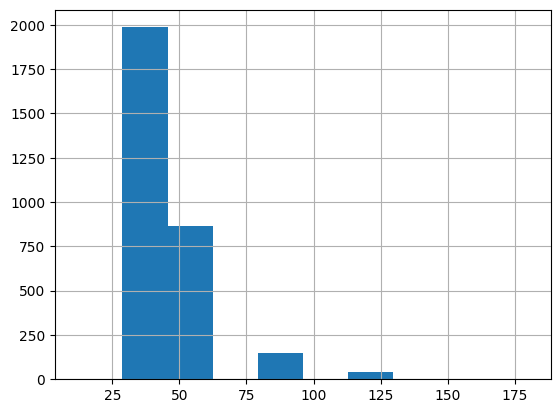

In [47]:
# Distribution of setoff times for parole denials
hearings[hearings["result"] == "Deny"]["setoff"].hist()

In [48]:
# Mean setoff time
hearings[hearings["result"] == "Deny"]["setoff"].mean()

46.372948128693366